# Xử lý tập dữ liệu CASIA-WebFace

## 1. Tải thư viện cần thiết

In [ ]:
!pip cache purge
!python -m pip install --upgrade pip

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install mxnet matplotlib kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 6.0 MB/s  0:00:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 112.2 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.21
    Uninstalling graphviz-0.21:
      Successfully uninstalled graphviz-0.21
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [mxnet]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
google-adk 1.21.0 requires graphviz<1.0.0,>=0.20.2, but you have graphviz 0.8.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have n

## 2. Tải tập dữ liệu

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("debarghamitraroy/casia-webface")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'casia-webface' dataset.
Path to dataset files: /kaggle/input/casia-webface


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/casia-webface/casia-webface/train.rec
/kaggle/input/casia-webface/casia-webface/train.idx
/kaggle/input/casia-webface/casia-webface/train.lst
/kaggle/input/casia-webface/casia-webface/property
/kaggle/input/casia-webface/eval/lfw.bin
/kaggle/input/casia-webface/eval/cfp_fp.bin
/kaggle/input/casia-webface/eval/calfw.bin
/kaggle/input/casia-webface/eval/agedb_30.bin
/kaggle/input/casia-webface/eval/sllfw.bin
/kaggle/input/casia-webface/eval/cplfw.bin
/kaggle/input/casia-webface/eval/talfw.bin
/kaggle/input/casia-webface/eval/cfp_ff.bin


In [ ]:
path_imgrec = "/kaggle/input/casia-webface/casia-webface/train.rec"
path_imgidx = "/kaggle/input/casia-webface/casia-webface/train.idx"

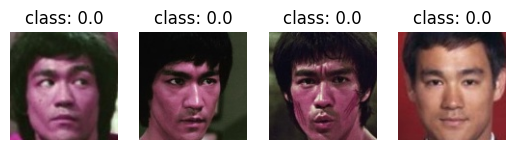

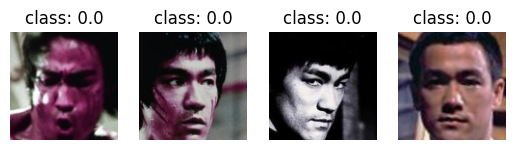

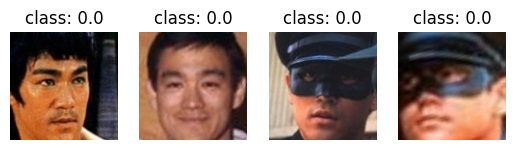

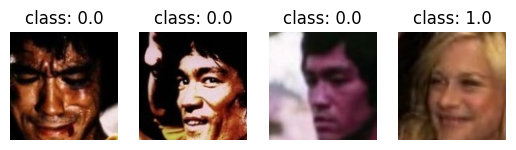

In [ ]:
import numpy as np
np.bool = bool
import mxnet as mx
from mxnet import recordio
import matplotlib.pyplot as plt

data_iter = mx.image.ImageIter(
    batch_size=4,
    data_shape=(3, 112, 112),
    path_imgrec=path_imgrec,
    path_imgidx=path_imgidx,
)
data_iter.reset()
for j in range(4):
    batch = data_iter.next()
    data = batch.data[0]
    # print(batch)
    label = batch.label[0].asnumpy()
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1, 2, 0)))
        ax.set_title("class: " + str(label[i]))
        plt.axis("off")
    plt.show()

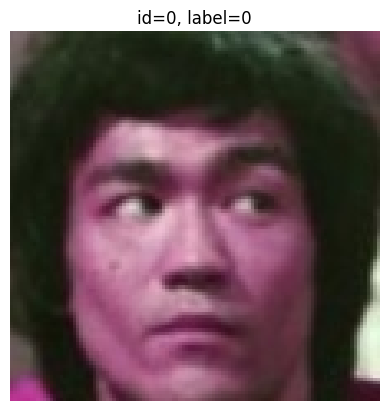

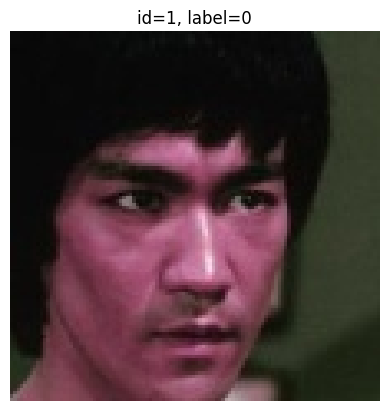

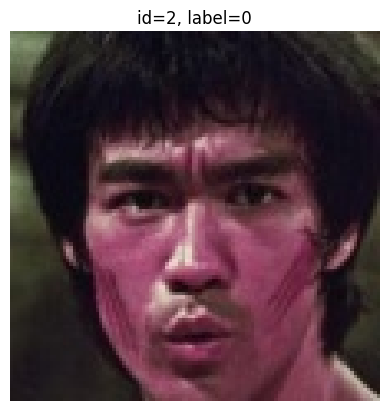

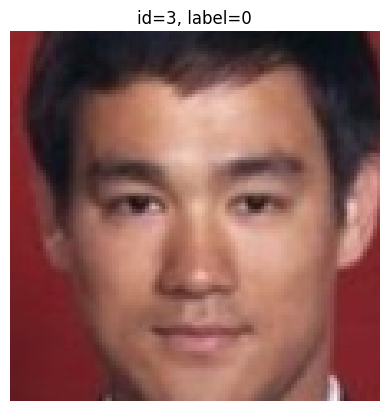

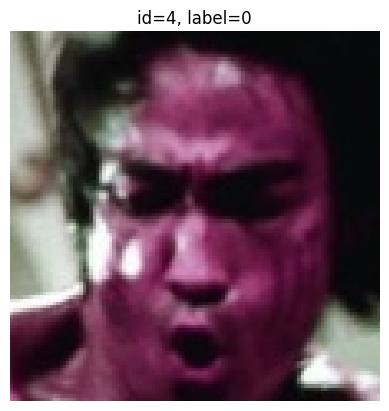

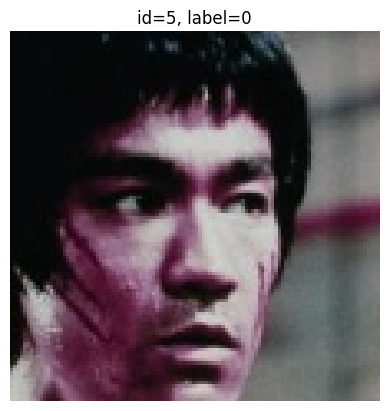

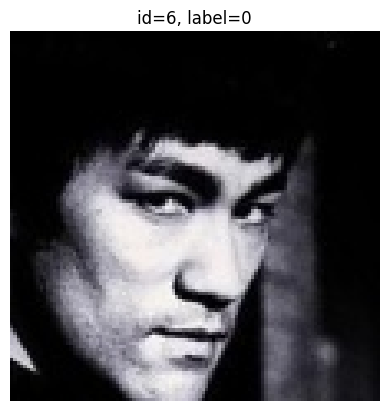

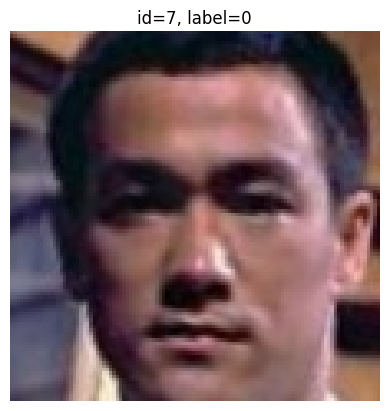

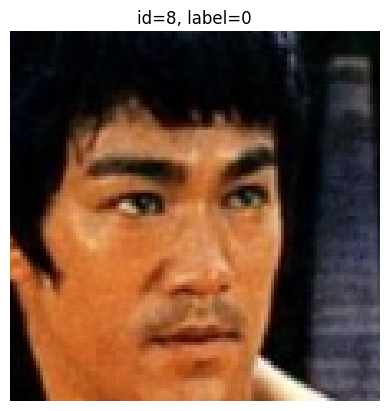

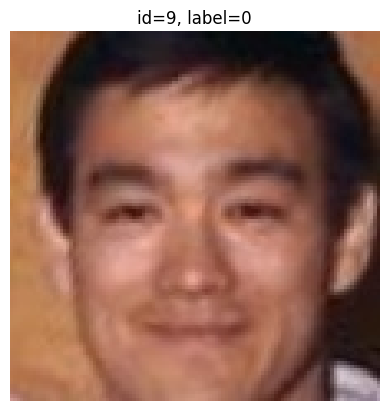

In [ ]:
imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, "r")

# %% 1 ~ 409623
# for i in range(409623):
for i in range(10):
    header, s = recordio.unpack(imgrec.read_idx(i + 1))
    img = mx.image.imdecode(s).asnumpy()
    plt.imshow(img)
    plt.title(f"id={i}, label={int(header.label)}")
    plt.axis("off")
    plt.show()

## 3. Lưu tập dữ liệu mới


In [ ]:
import os

# Tên thư mục dataset chính
main_directory_name = 'CASIA-WebFace-10K'
os.makedirs(main_directory_name, exist_ok=True)
print(f"Main directory '{main_directory_name}' ensured to exist.")

# Tên thư mục chứa ảnh
subdirectory_name = os.path.join(main_directory_name, 'extracted_images')
os.makedirs(subdirectory_name, exist_ok=True)
print(f"Subdirectory '{subdirectory_name}' ensured to exist.")

Main directory 'CASIA-WebFace-10K' ensured to exist.
Subdirectory 'CASIA-WebFace-10K/extracted_images' ensured to exist.


In [ ]:
import random

# Theo hướng dẫn trên Kaggle
total_images = 409623

# Số lượng ảnh mong muốn
num_images_to_extract = 10000

# Lấy 10.000 chỉ mục đầu tiên
indices = list(range(1, num_images_to_extract + 1))

print(f"Generated {len(indices)} sequential indices for image extraction.")

Generated 10000 sequential indices for image extraction.


In [ ]:
import cv2 # Sử dụng opencv-python để lưu ảnh
import pandas as pd

image_paths = []
labels = []
skipped_indices = []

print(f"Starting extraction of {len(indices)} images...")

for i, index in enumerate(indices):
    try:
        # Đọc bản ghi cho chỉ mục ngẫu nhiên hiện tại (recordio dựa trên 1)
        header, s = recordio.unpack(imgrec.read_idx(index))
        # Kiểm tra nếu 's' rỗng trước khi giải mã
        if not s:
            raise ValueError("Empty image buffer encountered.")

        img = mx.image.imdecode(s).asnumpy()

        # Chuyển đổi RGB sang BGR để lưu bằng OpenCV
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # Định nghĩa tên tệp và đường dẫn ảnh
        img_filename = f"image_{i:05d}.jpg"
        img_filepath_full = os.path.join(subdirectory_name, img_filename)

        # Lưu ảnh
        cv2.imwrite(img_filepath_full, img_bgr)

        # Lưu đường dẫn và nhãn. Đường dẫn phải tương đối so với thư mục chính
        relative_img_path = os.path.join(os.path.basename(subdirectory_name), img_filename)
        image_paths.append(relative_img_path)
        labels.append(int(header.label))

        if (i + 1) % 1000 == 0:
            print(f"Extracted {len(image_paths)}/{len(indices)} images.")

    except Exception as e:
        print(f"Error processing record at original index {index} (extracted sequence {i}): {e}. Skipping this image.")
        skipped_indices.append(index)
        continue # Bỏ qua bản ghi bị lỗi và tiếp tục với bản ghi tiếp theo

print(f"Finished extracting {len(image_paths)} images.")
if skipped_indices:
    print(f"Skipped {len(skipped_indices)} images due to errors at indices: {skipped_indices[:10]}...")

# Tạo DataFrame từ dữ liệu đã thu thập
df_labels = pd.DataFrame({"image_path": image_paths, "label": labels})

# Lưu DataFrame vào tệp CSV trong thư mục chính
csv_filepath = os.path.join(main_directory_name, "labels.csv")
df_labels.to_csv(csv_filepath, index=False)

print(f"Saved labels to '{csv_filepath}'.")

Starting extraction of 10000 images...
Extracted 1000/10000 images.
Extracted 2000/10000 images.
Extracted 3000/10000 images.
Extracted 4000/10000 images.
Extracted 5000/10000 images.
Extracted 6000/10000 images.
Extracted 7000/10000 images.
Extracted 8000/10000 images.
Extracted 9000/10000 images.
Extracted 10000/10000 images.
Finished extracting 10000 images.
Saved labels to 'CASIA-WebFace-10K/labels.csv'.


In [ ]:
import shutil
import os
from google.colab import files

# Nén thư mục 'CASIA-WebFace-10K' vào một tệp zip
output_filename = 'CASIA-WebFace-10K_archive'

# Thay đổi cách gọi make_archive để bao gồm thư mục gốc trong tệp zip
# root_dir là thư mục mà từ đó sẽ bắt đầu nén (thư mục hiện tại: /content)
# base_dir là thư mục con bên trong root_dir muốn nén
zip_file_path = shutil.make_archive(output_filename, 'zip', root_dir=os.getcwd(), base_dir=main_directory_name)

print(f"Created zip file: {zip_file_path}")

# Cung cấp liên kết để tải xuống tệp zip
try:
  files.download(zip_file_path)
except Exception as e:
  print(f"Error during download: {e}. You can manually download the file '{zip_file_path}' from the files panel.")

Created zip file: /content/CASIA-WebFace-10K_archive.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>